In [1]:
import os
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from PIL import ImageOps
import torch
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
from torch.utils.data import random_split

from torchvision import transforms
from PIL import ImageOps
from PIL import Image
from io import BytesIO
from IPython.display import display


import sys, os
sys.path.append(os.path.abspath("src"))

from data import count_images_per_class, quick_image_sanity_check
from viz import display_class_distribution




# Step 1: Data Analysis & Dataset Sample

## 1.1 Data Acquisition

The dataset used in this project is the [Fruits 360 dataset](https://www.kaggle.com/datasets/moltean/fruits), publicly available on Kaggle. It contains thousands of labeled fruit images in `.jpg` format, sorted into folders by fruit class. Each image is **100×100 pixels** and originally in **RGB format**.

We selected this dataset because:
- It includes a **wide variety of fruit classes** suitable for multi-class classification.
- Images are already **clean and labeled**, minimizing preprocessing effort.
- It is a well-known benchmark dataset for fruit classification tasks.
- The folder structure is compatible with **PyTorch’s `ImageFolder`**, making it easy to load.

---

## 1.2 Dataset Reduction & Cleaning

To simulate a more realistic and constrained edge-case scenario, we **manually selected 8 specific fruit categories** from the dataset. This allows us to:
- Focus the classification task on a smaller, balanced subset.
- Reduce dataset size for faster training and evaluation.
- Better explore model performance in a **low-data regime**.

We ensured that:
- The image dimensions are consistent (**100×100**).
- All images are intact and correctly labeled.
- Class balance is maintained across training and test splits.

Additionally, during preprocessing, all images are converted to **grayscale** to reduce input complexity and align with embedded system constraints.

---

## 1.3 Exploratory Data Analysis (EDA)

To confirm that our selected subset is suitable for fair training, we examined the **class distribution** using simple utility functions.

### Count Function:
```python
def count_images_per_class(directory):
    return {
        class_name: len(os.listdir(os.path.join(directory, class_name)))
        for class_name in os.listdir(directory)
        if os.path.isdir(os.path.join(directory, class_name))
    }




- <a href="01_eda.ipynb" target="_blank">01_eda.ipynb</a> — Exploratory Data Analysis & Dataset Sampling  



# Step 2: Image Preprocessing & Dataset Loading

In this step, we prepare our fruit image dataset for training and evaluation using PyTorch utilities. Preprocessing determines the format and structure of the data and directly affects training speed, model complexity, and overall performance — especially in small-scale, resource-constrained setups like embedded systems.

---

## 2.1 Project Hypotheses Supported

Our design is driven by three formal hypotheses:

1. **Grayscale Hypothesis**  
   > Grayscale input can be as effective as RGB for fruit classification, while reducing memory and compute requirements.

2. **Model Simplicity Hypothesis**  
   > A lightweight custom CNN can perform comparably to MobileNetV2, with significantly fewer resources.

3. **Quantization Hypothesis**  
   > Post-training quantization (float32 → int8) will reduce model size and inference time with minimal accuracy loss.

To support these hypotheses, we initially avoided RGB input and data augmentation. However, to further improve generalization and robustness, we now introduce **realistic grayscale-specific augmentations** only for the training set.

---

## 2.2 Preprocessing Strategy

Our preprocessing is designed for compatibility with embedded devices and small datasets, while simulating real-world imperfections that affect shape and lighting.

### Training-time augmentations (applied only to training set):

- **Convert to Grayscale + Histogram Equalization**  
  Enhances contrast and removes color variation by standardizing intensity distribution.

- **Random Horizontal Flip**  
  Simulates mirrored viewpoints.

- **Random Affine (±10° rotation + small translation)**  
  Introduces slight shifts and rotations to simulate camera or object variation.

- **ColorJitter (brightness and contrast)**  
  Simulates differences in lighting conditions.

- **Random Perspective Distortion**  
  Mimics natural viewpoint changes (e.g., lens perspective).

- **Random Shear**  
  Warps fruit shape slightly to help learn deformation-invariant features.

- **Resize to 100×100 pixels**  
  Reduces input size to balance detail with compute/memory constraints.

- **Normalize to [-1, 1]**  
  Ensures consistent scale across samples for stable gradient flow.

### Validation/Test-time preprocessing:

- Clean grayscale input  
- No augmentation  
- Resize → Normalize only

> These augmentations are **only applied to training data**. Validation and test sets remain unaugmented for fair evaluation.




In [3]:
# Histogram Equalization

def equalize_grayscale(img):
    return ImageOps.equalize(img.convert("L"))


# Augmented transform for training only
transform_gray_augmented = transforms.Compose([
    transforms.Lambda(equalize_grayscale),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),  # Slight rotation and shift
    transforms.ColorJitter(brightness=0.2, contrast=0.2),          # Lighting variation
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomAffine(degrees=10, shear=10),  # small shears simulate natural shape variance
])

# Clean transform for validation and test
transform_gray = transforms.Compose([
    transforms.Lambda(equalize_grayscale),
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])



## 2.3 Dataset Loading and Splitting

We use PyTorch’s `ImageFolder` and `DataLoader` APIs to load and split the dataset.

- The training set uses the **augmented grayscale transform**
- The validation and test sets use the **clean grayscale transform**

We also apply class balancing to handle imbalance in class frequencies using `CrossEntropyLoss` with custom weights.

In [4]:
# Load datasets
train_data = ImageFolder(TRAIN_DIR, transform=transform_gray_augmented)
test_data = ImageFolder(TEST_DIR, transform=transform_gray)

# Split train_data into training and validation
val_size = int(0.2 * len(train_data))
train_size = len(train_data) - val_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])

# Override val subset transform to use clean preprocessing
val_data = ImageFolder(TRAIN_DIR, transform=transform_gray)
val_subset.dataset = val_data

# Wrap in DataLoaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

# Analyze class distribution for imbalance
from collections import Counter
print(Counter([label for _, label in train_data.samples]))

Counter({7: 738, 0: 492, 6: 492, 2: 490, 3: 490, 5: 490, 4: 479, 1: 427})


####  Note: The class distribution is slightly imbalanced. Class weighting will be applied during training to prevent bias.

### 2.4 Visualization of Preprocessed Samples

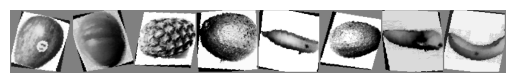

Image 1: Apple Red 1
Image 2: Tomato 1
Image 3: Pineapple 1
Image 4: Avocado 1
Image 5: Banana 1
Image 6: Avocado 1
Image 7: Banana 1
Image 8: Banana 1


In [5]:

def imshow(img, grayscale=False):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    if grayscale:
        npimg = npimg[0]
        plt.imshow(npimg, cmap='gray')
    else:
        npimg = np.transpose(npimg, (1, 2, 0))
        plt.imshow(npimg)
    plt.axis('off')
    plt.show()

# Preview 8 training samples
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images[:8]), grayscale=True)

for i in range(8):
    print(f"Image {i+1}: {train_data.classes[labels[i]]}")

### 2.5 Summary

This step produces:
- Augmented grayscale training data
- Clean grayscale validation and test data
- Consistent size and normalization across sets

These preprocessing pipelines are now ready to feed into our baseline CNN model (Step 3).

---

####  Note:
Although all data is stored and loaded in float32 by default, the model will be quantized to int8 precision after training (Step 6).


# Step 3: Model Building — Baseline CNN

In this step, we define, train, evaluate, and save our first convolutional neural network (CNN) model, which serves as a **performance baseline** for later comparison and quantization.

---

## 3.1 Objective

This step supports **Hypothesis 1**:  
> A lightweight CNN trained on grayscale fruit images can achieve reasonable classification accuracy, even with minimal augmentation.

It also prepares the model for:

- Comparison with MobileNetV2 (**Hypothesis 2**)  
- Post-training quantization (**Hypothesis 3**)

---

## 3.2 CNN Architecture (Grayscale-Compatible)

Our baseline CNN is compact and designed for `100×100` **grayscale images** (1 input channel), as established in Step 2.

It consists of:

- 3 convolutional layers with ReLU activation and MaxPooling  
- 2 fully connected layers with ReLU and Dropout  
- A final softmax classifier layer for 8-class output

> ✅ **Note**: The first convolutional layer uses `in_channels=1` to match the grayscale input format.

---

## 3.3 Training Configuration

- **Loss Function**: `CrossEntropyLoss` (for multi-class classification)  
- **Optimizer**: `Adam` (learning rate = 0.001)  
- **Batch Size**: 32  
- **Epochs**: 10  
- **Evaluation**: Accuracy on a validation set (split from training data)

> **Note** : Apply class weights to handle imbalance

---

## 3.4 Training Procedure

- The model trains over multiple epochs on the training subset  
- For each batch:
  - Gradients are cleared  
  - Loss is computed  
  - Weights are updated  
- After each epoch, performance is evaluated on the **validation subset**  
- We record and visualize:
  - Training loss per epoch  
  - Validation accuracy per epoch

---

## 3.5 Model Saving

After training, we save the model weights to disk for later use:

```python
torch.save(model.state_dict(), "fruit_cnn_baseline_with_val.pth")


In [18]:

# === Global results dictionary ===
results_summary = {}

# === Save Experiment Result ===
def save_experiment_result(
    name,
    train_losses,
    val_accuracies,
    test_accuracy,
    model=None,              # <- ново
    test_loader=None,        # <- ново
    class_names=None         # <- ново
):
    from io import BytesIO
    buf = BytesIO()
    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)

    results_summary[name] = {
        "test_accuracy": test_accuracy,
        "train_losses": train_losses,
        "val_accuracies": val_accuracies,
        "plot": buf,
        "model": model,                   
        "test_loader": test_loader,       
        "class_names": class_names        
    }
    
# === Model Factory ===
def create_fruit_cnn(pooling="max", input_channels=1, num_classes=8):
    if pooling not in ["max", "adaptiveavg"]:
        raise ValueError("Invalid pooling type. Use 'max' or 'adaptiveavg'.")

    pool1 = nn.MaxPool2d(2, 2)
    pool2 = nn.MaxPool2d(2, 2)
    pool3 = nn.AdaptiveAvgPool2d((12, 12)) if pooling == "adaptiveavg" else nn.MaxPool2d(2, 2)

    class FruitCNN(nn.Module):
        def __init__(self):
            super(FruitCNN, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(input_channels, 16, kernel_size=3, padding=1),
                nn.ReLU(),
                pool1,
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                pool2,
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                pool3
            )
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 12 * 12, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x

    return FruitCNN()

# === Training Function ===
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        train_losses.append(running_loss / len(train_loader))

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = correct / total
        val_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss:.4f}, Validation Accuracy: {accuracy:.4f}")

    return train_losses, val_accuracies

# === Evaluation Function ===
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return correct / total

# === Device & Class Weights ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_counts = [427, 490, 490, 490, 479, 490, 492, 738]
class_weights = [1.0 / c for c in class_counts]
class_weights = torch.FloatTensor(class_weights).to(device)

# === Run Full Baseline Experiment ===
def run_baseline_experiment(pooling="max", input_channels=1, experiment_name="Grayscale MaxPool Baseline", 
                            train_loader=None, val_loader=None, test_loader=None, epochs=10):

    model = create_fruit_cnn(pooling=pooling, input_channels=input_channels).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, epochs)
    test_accuracy = evaluate_model(model, test_loader)

    # Save model and results
    torch.save(model.state_dict(), f"{experiment_name.replace(' ', '_')}.pth")
    save_experiment_result(
        experiment_name,
        train_losses,
        val_accuracies,
        test_accuracy,
        model=model,
        test_loader=test_loader,
        class_names=train_loader.dataset.dataset.classes
    )

    print()
    return test_accuracy, model, test_loader

# run base scenario with maxPool
test_accuracy_adaptive, model, test_loader = run_baseline_experiment(              
    input_channels=1,                      
    experiment_name="Grayscale MaxPool",
    train_loader=train_loader,             
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=10
)


Epoch [1/10], Loss: 89.2398, Validation Accuracy: 0.9560
Epoch [2/10], Loss: 30.2487, Validation Accuracy: 0.9829
Epoch [3/10], Loss: 19.3748, Validation Accuracy: 1.0000
Epoch [4/10], Loss: 10.5214, Validation Accuracy: 0.9988
Epoch [5/10], Loss: 11.9604, Validation Accuracy: 1.0000
Epoch [6/10], Loss: 7.7458, Validation Accuracy: 1.0000
Epoch [7/10], Loss: 4.4496, Validation Accuracy: 1.0000
Epoch [8/10], Loss: 3.4924, Validation Accuracy: 1.0000
Epoch [9/10], Loss: 4.0307, Validation Accuracy: 1.0000
Epoch [10/10], Loss: 2.7356, Validation Accuracy: 1.0000



#### 3.6.1  Visualize Misclassified Test Images # todo detailed explanation


In [ ]:

# Class labels from the dataset (adjust to match your classes if needed)
class_names = test_data.classes

# Collect misclassified samples
misclassified = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        for i in range(len(labels)):
            if predicted[i] != labels[i]:
                misclassified.append((images[i].cpu(), labels[i].cpu(), predicted[i].cpu()))

#### 3.6.2 Display a Few Misclassified Examples

In [ ]:
num_to_show = min(12, len(misclassified))
plt.figure(figsize=(15, 10))

for idx in range(num_to_show):
    img_tensor, true_label, pred_label = misclassified[idx]
    img = img_tensor.squeeze().numpy()  # Convert from tensor to 2D numpy array

    plt.subplot(3, 4, idx + 1)
    plt.imshow(img, cmap='gray')
    plt.title(f"True: {class_names[true_label]}\nPred: {class_names[pred_label]}")
    plt.axis('off')

plt.suptitle("Misclassified Test Images", fontsize=16)
plt.tight_layout()
plt.show()

#### 3.7 Improved CNN with Adaptive Pooling 

In [9]:

# Run the baseline experiment with AdaptiveAvgPool instead of MaxPool
test_accuracy_adaptive = run_baseline_experiment(
    pooling="adaptiveavg",                 # Use adaptive pooling
    input_channels=1,                      # Grayscale input
    experiment_name="Grayscale AdaptiveAvgPool",
    train_loader=train_loader,             
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=10
)

Epoch [1/10], Loss: 82.0094, Validation Accuracy: 0.9475
Epoch [2/10], Loss: 26.8353, Validation Accuracy: 0.9963
Epoch [3/10], Loss: 18.8181, Validation Accuracy: 0.9915
Epoch [4/10], Loss: 12.6948, Validation Accuracy: 1.0000
Epoch [5/10], Loss: 9.5585, Validation Accuracy: 0.9963
Epoch [6/10], Loss: 6.5383, Validation Accuracy: 0.9988
Epoch [7/10], Loss: 5.9607, Validation Accuracy: 1.0000
Epoch [8/10], Loss: 4.7973, Validation Accuracy: 1.0000
Epoch [9/10], Loss: 4.3587, Validation Accuracy: 1.0000
Epoch [10/10], Loss: 2.4276, Validation Accuracy: 1.0000



* Despite expectations, max-pooling outperforms adaptive average pooling on both validation and test sets. This suggests that fine-grained textural activations are more helpful than global shape layout for this task, possibly due to lighting, resolution, or dataset scale.

## 3.8 CNN with RGB Input

In this step, we extend our investigation by training the lightweight CNN model on **RGB images** instead of grayscale. This allows us to evaluate the **Grayscale Hypothesis**:

> *Grayscale input can be as effective as RGB for fruit classification, while reducing memory and compute requirements.*

By using the same model architecture with RGB inputs (3 channels), we can quantify any performance difference.



### 3.8.1 Preprocessing for RGB Input

We now define a preprocessing pipeline for RGB images. This includes light augmentations for the training set and clean normalization for validation and test sets.

In [10]:
# RGB Preprocessing for Training

def get_rgb_transforms(use_noise=True):
    """Return training and test transforms for RGB images"""
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        transforms.RandomAffine(degrees=10, translate=(0.05, 0.05)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2),
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    
    if use_noise:
        transform_train.transforms.extend([
            transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
            transforms.RandomErasing(p=0.3, scale=(0.02, 0.1))
        ])
    
    transform_test = transforms.Compose([
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
    ])
    
    return transform_train, transform_test

### 3.8.2 RGB Dataset Loading and Splitting
We load the RGB dataset using PyTorch’s ImageFolder and apply appropriate transforms. The validation set is split from the training set, same as in the grayscale case.

In [11]:
def load_rgb_dataloaders(train_dir, test_dir, batch_size=32, use_noise=True):
    transform_train, transform_test = get_rgb_transforms(use_noise)

    # Train + Validation split
    full_train = ImageFolder(train_dir, transform=transform_train)
    test_data = ImageFolder(test_dir, transform=transform_test)

    val_size = int(0.2 * len(full_train))
    train_size = len(full_train) - val_size
    train_subset, val_subset = random_split(full_train, [train_size, val_size])

    # Override val subset to use clean transforms
    clean_val_data = ImageFolder(train_dir, transform=transform_test)
    val_subset.dataset = clean_val_data

    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


### 3.8.3 Modify CNN Architecture for RGB Input
We adjust the CNN to accept 3-channel (RGB) images instead of grayscale.


In [12]:
def create_fruit_cnn_rgb(pooling="max", num_classes=8):
    if pooling not in ["max", "adaptiveavg"]:
        raise ValueError("Invalid pooling type. Choose 'max' or 'adaptiveavg'.")

    pool1 = nn.MaxPool2d(2, 2)
    pool2 = nn.MaxPool2d(2, 2)
    pool3 = nn.AdaptiveAvgPool2d((12, 12)) if pooling == "adaptiveavg" else nn.MaxPool2d(2, 2)

    class FruitCNN_RGB(nn.Module):
        def __init__(self):
            super(FruitCNN_RGB, self).__init__()
            self.conv_layers = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, padding=1),  # 3 channels for RGB
                nn.ReLU(),
                pool1,
                nn.Conv2d(16, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                pool2,
                nn.Conv2d(32, 64, kernel_size=3, padding=1),
                nn.ReLU(),
                pool3
            )
            self.fc_layers = nn.Sequential(
                nn.Flatten(),
                nn.Linear(64 * 12 * 12, 256),
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(256, num_classes)
            )

        def forward(self, x):
            x = self.conv_layers(x)
            x = self.fc_layers(x)
            return x

    return FruitCNN_RGB()


def run_rgb_experiment(pooling="max", use_noise=True, experiment_name="RGB CNN", 
                       train_dir=TRAIN_DIR, test_dir=TEST_DIR, epochs=10, batch_size=32):
    """
    Trains and evaluates an RGB-compatible CNN, using optional noise and pooling configuration.
    Saves model and stores results in global dictionary.
    """

    # Load Data
    train_loader, val_loader, test_loader, full_dataset = load_rgb_dataloaders(
        train_dir, test_dir, batch_size=batch_size, use_noise=use_noise
    )

    # Initialize Model
    model = create_fruit_cnn_rgb(pooling=pooling).to(device)

    # Set up Loss and Optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
 
    # Train
    train_losses, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs
    )

    # Evaluate
    test_accuracy = evaluate_model(model, test_loader)

    # Save Model
    torch.save(model.state_dict(), f"{experiment_name.replace(' ', '_')}.pth")

    # Save Results to Global Dictionary with Plot + Confusion Matrix Info
    save_experiment_result(
        experiment_name,
        train_losses,
        val_accuracies,
        test_accuracy,
        model=model,
        test_loader=test_loader,
        class_names=full_dataset.classes
    )

    return test_accuracy, model, test_loader



### 3.8.4 Train and Evaluate RGB CNN
We train the RGB-compatible CNN using the same procedure as in Step 3, but now we consider the effect of training noise.

#### 3.8.4.1 RGB CNN With Noise

In this configuration, the training images were augmented with additional noise:
- Gaussian blur
- Random erasing
- Horizontal flip, affine transform, color jitter

We aim to simulate more realistic and degraded conditions, and observe model robustness.

In [13]:
run_rgb_experiment(
    pooling="max",
    use_noise=True,
    experiment_name="RGB CNN With Noise"
)


Epoch [1/10], Loss: 47.6823, Validation Accuracy: 0.9951
Epoch [2/10], Loss: 3.8588, Validation Accuracy: 1.0000
Epoch [3/10], Loss: 6.2348, Validation Accuracy: 1.0000
Epoch [4/10], Loss: 1.0094, Validation Accuracy: 1.0000
Epoch [5/10], Loss: 1.4960, Validation Accuracy: 1.0000
Epoch [6/10], Loss: 1.9211, Validation Accuracy: 1.0000
Epoch [7/10], Loss: 0.6886, Validation Accuracy: 1.0000
Epoch [8/10], Loss: 1.6584, Validation Accuracy: 1.0000
Epoch [9/10], Loss: 1.8806, Validation Accuracy: 1.0000
Epoch [10/10], Loss: 1.5926, Validation Accuracy: 1.0000


0.8857142857142857

#### 3.8.4.2 RGB CNN Without Noise

In this version, we disable noise and only apply geometric and color augmentations:
- Horizontal flip
- Affine transform
- Color jitter

In [14]:
run_rgb_experiment(
    pooling="max",
    use_noise=False,
    experiment_name="RGB CNN Without Noise"
)

Epoch [1/10], Loss: 45.2020, Validation Accuracy: 0.9976
Epoch [2/10], Loss: 4.2269, Validation Accuracy: 0.9976
Epoch [3/10], Loss: 3.4811, Validation Accuracy: 1.0000
Epoch [4/10], Loss: 0.4700, Validation Accuracy: 1.0000
Epoch [5/10], Loss: 1.9075, Validation Accuracy: 1.0000
Epoch [6/10], Loss: 1.5741, Validation Accuracy: 1.0000
Epoch [7/10], Loss: 0.7389, Validation Accuracy: 1.0000
Epoch [8/10], Loss: 3.3102, Validation Accuracy: 1.0000
Epoch [9/10], Loss: 1.2876, Validation Accuracy: 1.0000
Epoch [10/10], Loss: 0.5063, Validation Accuracy: 1.0000


0.8857142857142857

### 3.8.5 Result Interpretation

In this step, we analyze the results from all baseline CNN experiments — both grayscale and RGB variants.

We aim to answer:

- **Was the performance gain from using RGB worth the extra memory and compute cost?**
- **Did RGB significantly improve the test accuracy?**
- **Does grayscale still provide a good enough tradeoff for embedded or low-resource devices?**

By plotting and comparing all recorded test accuracies and training dynamics, we can draw clear conclusions to support or reject our hypotheses.

The following experiments are compared:

- **Grayscale CNN with MaxPooling**
- **Grayscale CNN with AdaptiveAvgPooling**
- **RGB CNN with Noise Augmentation**
- **RGB CNN without Noise**


=== CNN Experiment Comparison ===


Grayscale MaxPool: Test Accuracy = 0.8777
📊 Plot for Grayscale MaxPool


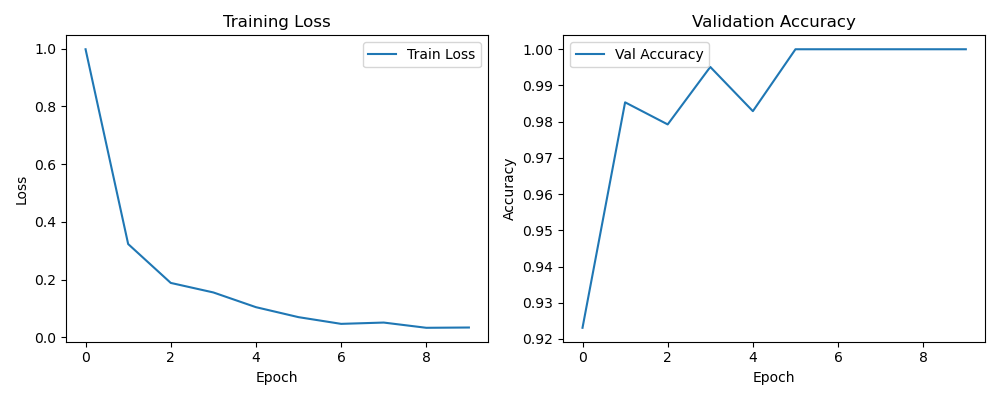


Grayscale AdaptiveAvgPool: Test Accuracy = 0.8850
📊 Plot for Grayscale AdaptiveAvgPool


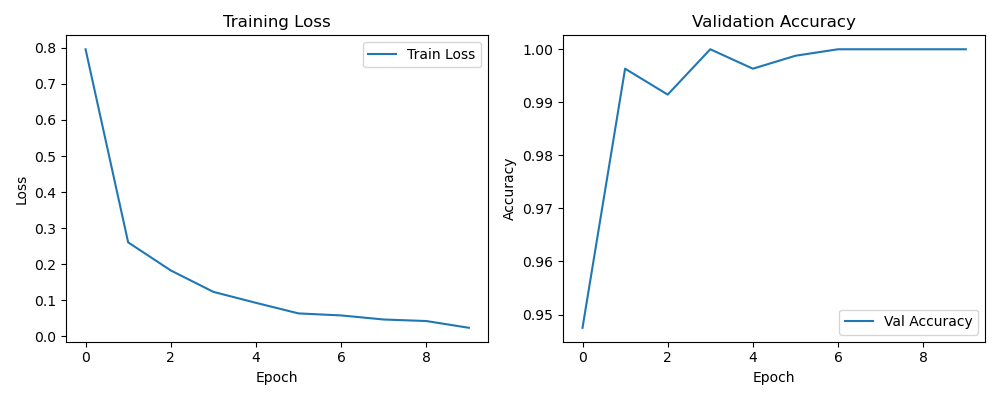


RGB CNN With Noise: Test Accuracy = 0.8857
📊 Plot for RGB CNN With Noise


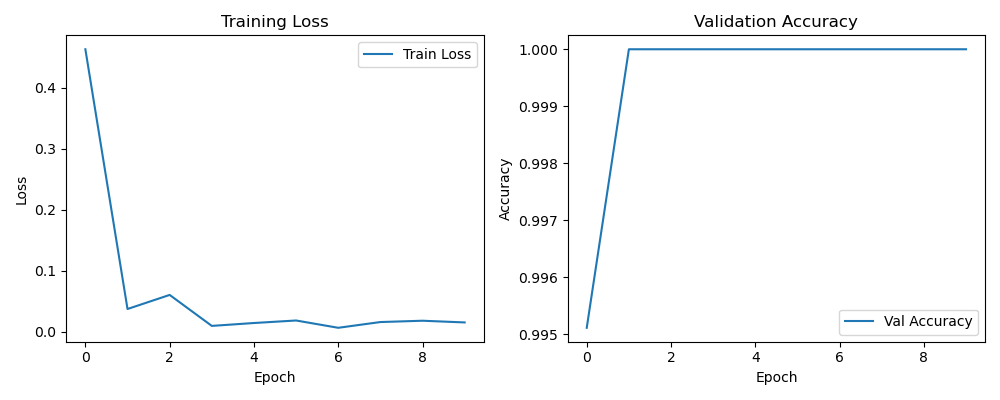


RGB CNN Without Noise: Test Accuracy = 0.8857
📊 Plot for RGB CNN Without Noise


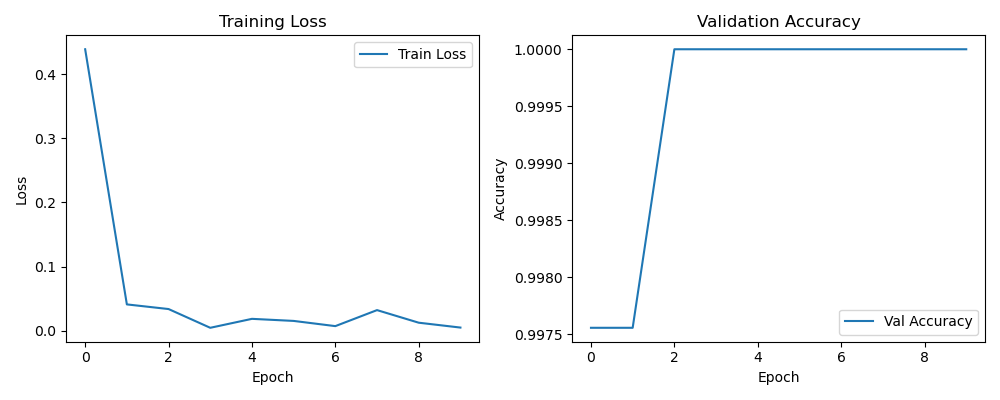

In [15]:

# Visual Summary: Show All Plots from results_summary
print("=== CNN Experiment Comparison ===\n")
for name, result in results_summary.items():
    print(f"\n{name}: Test Accuracy = {result['test_accuracy']:.4f}")

    # Show the stored plot
    print(f"📊 Plot for {name}")
    image = Image.open(result['plot'])
    display(image)

In [16]:

def load_grayscale_dataloaders(train_dir, test_dir, batch_size=32, val_split=0.2):
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize((100, 100)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])

    # Load full dataset
    full_dataset = ImageFolder(train_dir, transform=transform)

    # Split into train and val
    val_size = int(val_split * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    # Test set
    test_set = ImageFolder(test_dir, transform=transform)

    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size, shuffle=False),
        DataLoader(test_set, batch_size=batch_size, shuffle=False),
        full_dataset  # for class names
    )


def load_rgb_dataloaders(train_dir, test_dir, batch_size=32, use_noise=False, val_split=0.2):
    if use_noise:
        transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),
            transforms.ToTensor(),  # <- this must come BEFORE RandomErasing
            transforms.RandomErasing(p=0.5),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((100, 100)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
        ])

    full_dataset = ImageFolder(train_dir, transform=transform)
    val_size = int(val_split * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

    test_set = ImageFolder(test_dir, transform=transform)

    return (
        DataLoader(train_set, batch_size=batch_size, shuffle=True),
        DataLoader(val_set, batch_size=batch_size, shuffle=False),
        DataLoader(test_set, batch_size=batch_size, shuffle=False),
        full_dataset
    )

def run_mobilenet_experiment(input_type="grayscale", use_noise=False, pooling="default",
                             experiment_name="MobileNetV2", train_dir=TRAIN_DIR, test_dir=TEST_DIR,
                             epochs=10, batch_size=32):
    """
    Trains and evaluates MobileNetV2 under multiple conditions:
    - input_type: 'grayscale' or 'rgb'
    - use_noise: applies data augmentation if True
    - pooling: 'default', 'max', or 'adaptive'
    """

    # === Load Data ===
    if input_type == "rgb":
        train_loader, val_loader, test_loader, _ = load_rgb_dataloaders(
            train_dir, test_dir, batch_size=batch_size, use_noise=use_noise
        )
        in_channels = 3
    else:
        train_loader, val_loader, test_loader, _ = load_grayscale_dataloaders(
            train_dir, test_dir, batch_size=batch_size 
        )
        in_channels = 1

    # === Load Pretrained MobileNetV2 ===
    mobilenet = models.mobilenet_v2(pretrained=True)

    # Modify Input Layer to Accept Grayscale or RGB
    mobilenet.features[0][0] = nn.Conv2d(in_channels, 32, kernel_size=3, stride=2, padding=1, bias=False)

    # Inject custom pooling if requested
    if pooling == "max":
        # Insert MaxPool after the first conv layer
        pooling_layer = nn.MaxPool2d(kernel_size=2, stride=2)
        mobilenet.features = nn.Sequential(
            mobilenet.features[0],
            pooling_layer,
            *mobilenet.features[1:]
        )
    elif pooling == "adaptive":
        # Insert AdaptiveAvgPool
        pooling_layer = nn.AdaptiveAvgPool2d(output_size=(56, 56))  # matches MobileNetV2 early size
        mobilenet.features = nn.Sequential(
            mobilenet.features[0],
            pooling_layer,
            *mobilenet.features[1:]
        )
    elif pooling != "default":
        raise ValueError("Invalid pooling type. Choose 'default', 'max', or 'adaptive'.")

    # Modify Output Layer
    num_ftrs = mobilenet.classifier[1].in_features
    mobilenet.classifier[1] = nn.Linear(num_ftrs, 8)

    mobilenet = mobilenet.to(device)

    # === Train ===
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(mobilenet.parameters(), lr=0.001)

    train_losses, val_accuracies = train_model(mobilenet, train_loader, val_loader, criterion, optimizer, epochs)

    # === Evaluate ===
    test_accuracy = evaluate_model(mobilenet, test_loader)

    # === Save Model and Summary ===
    torch.save(mobilenet.state_dict(), f"{experiment_name.replace(' ', '_')}.pth")
    save_experiment_result(experiment_name, train_losses, val_accuracies, test_accuracy)

    return test_accuracy, mobilenet, test_loader


# 1. Grayscale with MaxPool
test_accuracy, _ , _ = run_mobilenet_experiment(
    input_type="grayscale",
    pooling="max",
    experiment_name="MobileNetV2 Grayscale MaxPool"
)
print(test_accuracy)
# 2. Grayscale with AdaptiveAvgPool
test_accuracy, _ , _ = run_mobilenet_experiment(
    input_type="grayscale",
    pooling="adaptive",
    experiment_name="MobileNetV2 Grayscale Adaptive"
)
print(test_accuracy)
# 3. RGB with Noise
test_accuracy, _ , _ = run_mobilenet_experiment(
    input_type="rgb",
    use_noise=True,
    pooling="default",
    experiment_name="MobileNetV2 RGB With Noise"
)
print(test_accuracy)
# 4. RGB Clean (no noise)
test_accuracy, _ , _ = run_mobilenet_experiment(
    input_type="rgb",
    use_noise=False,
    pooling="default",
    experiment_name="MobileNetV2 RGB Clean"
)
print(test_accuracy)


# Visual Summary: Show All Plots from results_summary
print("=== CNN Experiment Comparison of pretrained MobileNetV2 ===\n")
for idx, (name, result) in enumerate(results_summary.items(), start=1):
    if idx < 5:  # skip first 4 results of the custom models
        continue

    print(f"\nResult #{idx}: {name}")
    print(f"Test Accuracy = {result['test_accuracy']:.4f}")

    # Show the stored plot
    print(f"📊 Plot for {name}")
    image = Image.open(result['plot'])
    display(image)

NameError: name 'models' is not defined

# Step 4. Model Evaluation & Metrics

### In this step, we evaluate our trained CNN to assess whether it meets the expectations of Hypothesis 1:
> *"A convolutional neural network (CNN) can accurately classify fruit images into 8 classes."*

We perform the following evaluations:

1. **Classification Report**
   - Computes precision, recall, F1-score for each fruit class.
   - Helps us understand how well the model predicts each category.

2. **Confusion Matrix**
   - A matrix showing how often classes are correctly or incorrectly predicted.
   - Reveals patterns of misclassification between similar-looking fruits.

3. **Overall Accuracy**
   - The percentage of correctly predicted images in the test set.

These metrics provide insight into the model's strengths and weaknesses, and allow us to determine whether the model is suitable for real-world use or needs further improvement.


In [ ]:
# Put model in evaluation mode
model.eval()

# Gather predictions and true labels
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Get class names from dataset
class_names = test_data.classes

# Print classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()